In [1]:
using Pkg
pkg"activate ."

In [2]:
using PerlaTonettiWaugh, Plots

┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.0/PerlaTonettiWaugh/Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1190


In [3]:
# Define common objects. 
params = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

d_0 = params.d_0
d_T = params.d_T
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [4]:
# use E_nodes of length 15
L = 15

settings = merge(settings, (transition_x0 = fill(0.0, length(settings.transition_x0)), 
                            transition_lb = fill(0.0, L-2),
                            transition_ub = fill(0.0, L-2),
                            E_node_count = L,
                            entry_residuals_nodes_count = L,
                            transition_weights = [fill(15, 3); fill(1, L-3)]));

In [5]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0));

In [7]:
@time settings, results = solve_continuation(3.07, # d_0 value
                        2.5019, # d_T value
                        step = 0.005, # default is 0.005 
                        params = params_T, 
                        settings = settings,
                        solver = solve_full_model_newuoa) # default is solve_full_model_python

7046.314602 seconds (26.17 G allocations: 13.453 TiB, 28.62% gc time)


((z_max = 5, z = [0.0, 0.000250627, 0.000501253, 0.00075188, 0.00100251, 0.00125313, 0.00150376, 0.00175439, 0.00200501, 0.00225564  …  4.63636, 4.67677, 4.71717, 4.75758, 4.79798, 4.83838, 4.87879, 4.91919, 4.9596, 5.0], Δ_E = 1.0e-6, iterations = 2, ode_solve_algorithm = Sundials.CVODE_BDF{:Newton,:Dense}(0, 0, 0, 0, false, 10, 5, 7, 3, 10), g_node_count = 30, T = 40.0, t = 0.0:4.444444444444445:40.0, g = [0.0306157, 0.0406157, 0.0506157, 0.0606157, 0.0706157, 0.0806157, 0.0906157, 0.100616, 0.110616, 0.120616], E_node_count = 15, entry_residuals_nodes_count = 15, transition_x0 = [-1.21551, -4.36997e-5, -0.076254, -0.0357683, -0.000425724, -0.000256096, -1.18135e-6, -1.27405e-8, -5.36997e-8, -8.39121e-5, -5.21479e-5, -0.0101759, -2.50136e-5, -0.000151258], transition_lb = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], transition_ub = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], transition_iterations = 2, transition_weights = [15, 15

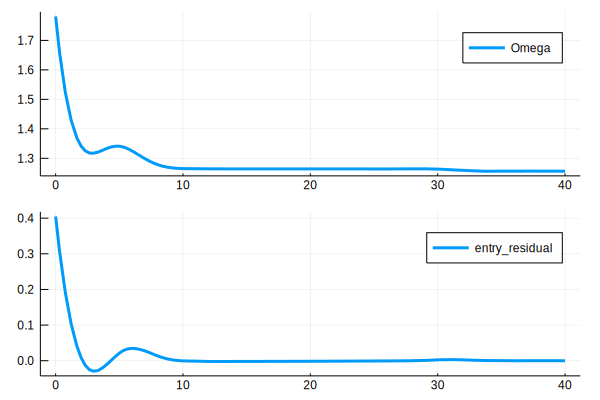

In [28]:
solved = results.solution.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

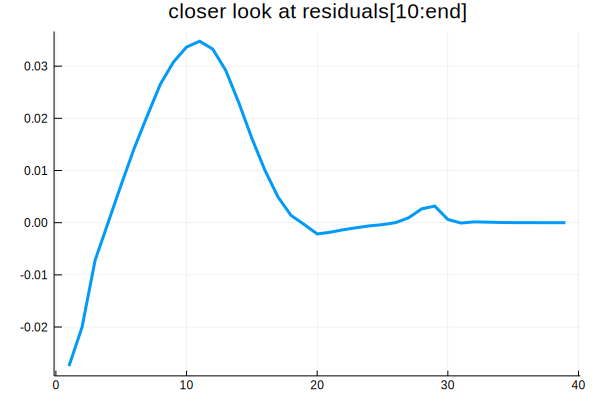

In [41]:
plot(solved.entry_residual[10:end], legend = :none, lw = 3, title = "closer look at residuals[10:end]")

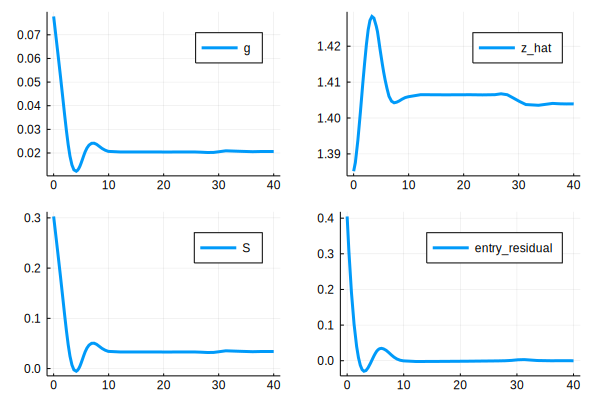

In [29]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

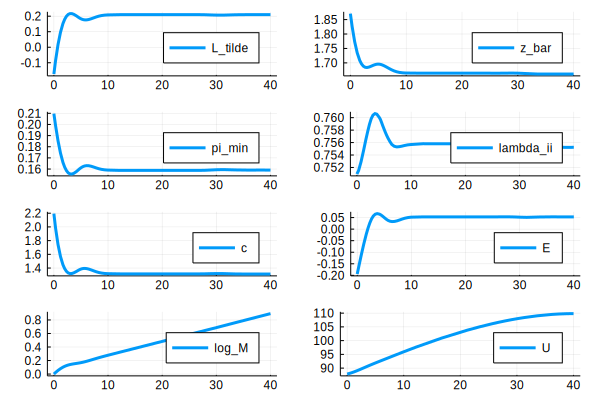

In [30]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

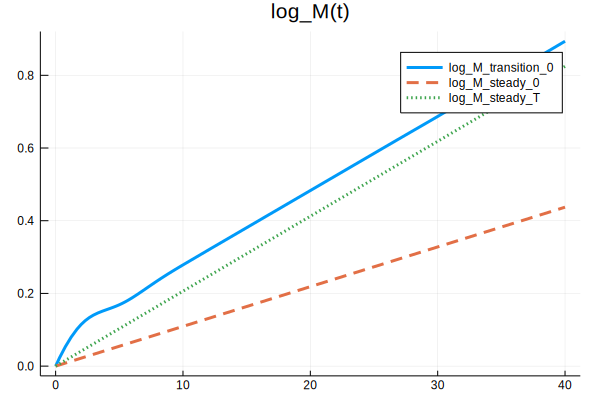

In [31]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

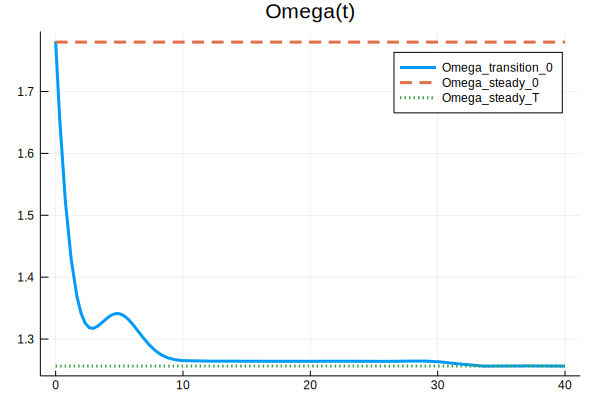

In [32]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

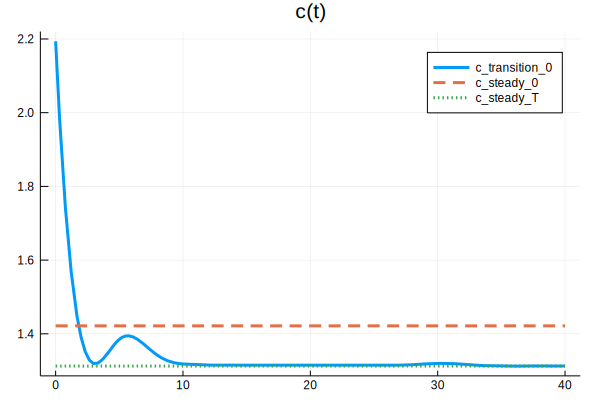

In [33]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

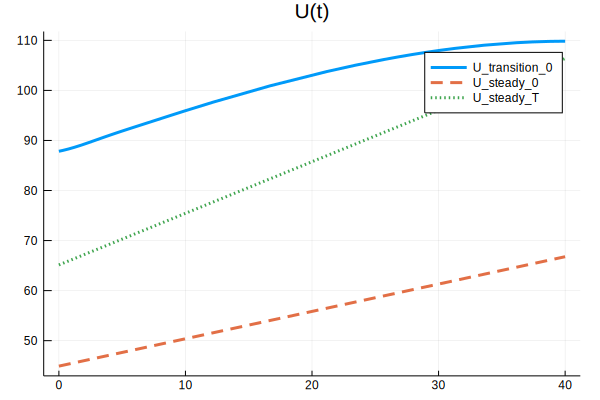

In [34]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

In [35]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), params)

2.365309706958876

In [36]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), params)

1.5238658206517042